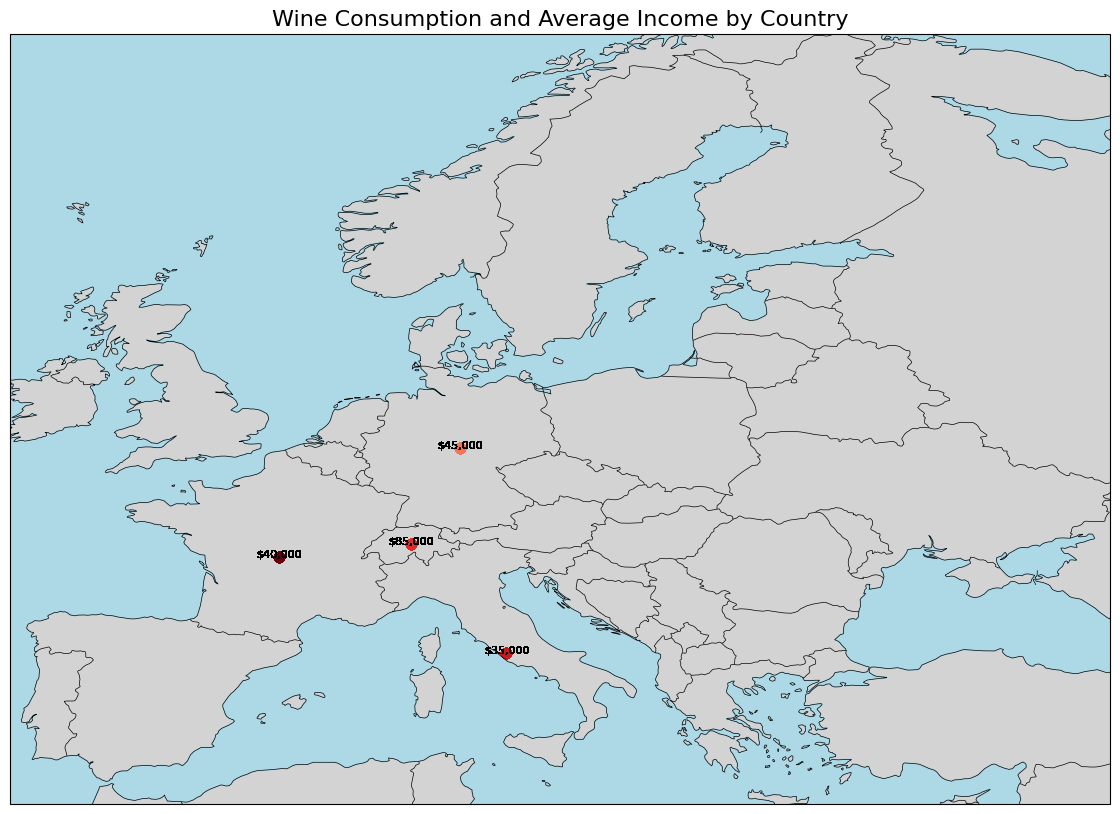

In [2]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Step 1: Read the income data from the CSV file
income_data = pd.read_csv("../data/raw/avg_income.csv")

# Step 2: Connect to the MySQL database and read the consumption data
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="rootroot",
    database="wines"
)

cursor = connection.cursor()

# Read the Consumption table and join it with Countries to get country names, codes, and coordinates
query = """
SELECT c.country_code, c.country_name, c.latitude, c.longitude, co.consumption_in_l
FROM Consumption co
JOIN Countries c ON co.country_id = c.country_id;
"""
cursor.execute(query)
consumption_data = pd.DataFrame(cursor.fetchall(), columns=['country_code', 'country_name', 'latitude', 'longitude', 'consumption_in_l'])

# Close the database connection
cursor.close()
connection.close()

# Step 3: Merge the income data with the consumption data
merged_data = consumption_data.merge(income_data, left_on="country_code", right_on="country", how="inner")

# Step 4: Prepare the data for visualization
# Normalize consumption for coloring
max_consumption = merged_data['consumption_in_l'].max()
merged_data['normalized_consumption'] = merged_data['consumption_in_l'] / max_consumption

# Ensure normalized_consumption is numeric and in range [0, 1]
merged_data['normalized_consumption'] = pd.to_numeric(merged_data['normalized_consumption'], errors='coerce').fillna(0)

# Step 5: Plot the map
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='lightblue')

# Add data points
for _, row in merged_data.iterrows():
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']):
        ax.scatter(
            row['longitude'], 
            row['latitude'], 
            color=plt.cm.Reds(row['normalized_consumption']), 
            s=50, 
            transform=ccrs.PlateCarree()
        )
        ax.text(
            row['longitude'], 
            row['latitude'], 
            f"${row['avg_income']:,.0f}", 
            fontsize=8, 
            transform=ccrs.PlateCarree(),
            ha="center"
        )

# Add title
plt.title("Wine Consumption and Average Income by Country", fontsize=16)
plt.show()